In [59]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import os
import sys
from pathlib import Path
import json
import torch
from IPython.display import display, HTML
import ipywidgets as widgets
from typing import List, Tuple, Dict, Optional
import time

sys.path.append(os.path.abspath('.'))
sys.path.append(os.path.abspath('./utils'))

from facedetector import FaceDetector

In [60]:
#DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = 'cpu'
print(f'Using device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"}')

Using device: NVIDIA GeForce RTX 4050 Laptop GPU


# Define FaceDetector and test it

In [61]:
class FaceDetectionPipeline:
    """
    Full pipeline for face detection + options for visualization and saving crops.
    """
    
    def __init__(self, config_path=None, weights_path=None, device='cpu'):
        self.detector = FaceDetector(config_path, weights_path, device=device)
    
    def detect_faces_in_image(self, image_path: str, confidence_threshold: float = 0.9) -> Dict:
        """
        Detect faces in a single img
        """
        # Load img
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Detection
        start_time = time.time()
        faces, landmarks = self.detector.detect(image, conf_thr=confidence_threshold)
        detection_time = time.time() - start_time
        
        # Filter using confidence threshold
        if len(faces) > 0:
            valid_faces = faces[faces[:, -1] >= confidence_threshold]
        else:
            valid_faces = faces
        
        results = {
            'image_original': image_rgb,
            'image_bgr': image, 
            'faces': valid_faces,
            'landmarks': landmarks,
            'detection_time': detection_time,
            'num_faces': len(valid_faces),
            'image_shape': image_rgb.shape
        }
        
        return results
    
    def visualize_detections(self, results: Dict, show_landmarks: bool = True, 
                           figsize: Tuple[int, int] = (12, 8)) -> None:
        """
        Visualize detection results using bounding boxes in the original content
        """
        image = results['image_original']
        faces = results['faces']
        landmarks = results['landmarks']
        
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        ax.imshow(image)
        
        # Draw bounding boxes
        for i, face in enumerate(faces):
            x1, y1, x2, y2, conf = face
            
            width = x2 - x1
            height = y2 - y1
            
            rect = Rectangle((x1, y1), width, height, 
                           linewidth=1, edgecolor='lightgreen', facecolor='none')
            ax.add_patch(rect)
            
            # Add label with confidence score
            ax.text(x1, y1-5, f'Face {i+1}: {conf:.2f}', 
                   color='lightgreen', fontsize=10, fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.5))
            
            # Show landmarks if availables
            if show_landmarks and landmarks is not None and len(landmarks) > i:
                face_landmarks = landmarks[i]
                if face_landmarks.size > 0:
                    for point in face_landmarks:
                        ax.plot(point[0], point[1], 'bo', markersize=1)
        
        ax.set_title(f'Face Detection - {results["num_faces"]} faces detected\n'
                    f'Processing time: {results["detection_time"]:.3f}s', 
                    fontsize=14, fontweight='bold')
        ax.axis('off')
        plt.tight_layout()
        plt.show()
        
    def extract_face_crops(self, results: Dict, padding: float = 0.2, 
                          target_size: Optional[Tuple[int, int]] = (160, 160)) -> List[np.ndarray]:
        """
        Estract face crops from the original image based on detected bounding boxes.
        """
        image = results['image_original']
        faces = results['faces']
        
        face_crops = []
        h, w = image.shape[:2]
        
        for i, face in enumerate(faces):
            x1, y1, x2, y2, conf = face
            
            # Padding
            face_w = x2 - x1
            face_h = y2 - y1
            pad_w = int(face_w * padding)
            pad_h = int(face_h * padding)
            # Coordinates
            x1_pad = max(0, int(x1 - pad_w))
            y1_pad = max(0, int(y1 - pad_h))
            x2_pad = min(w, int(x2 + pad_w))
            y2_pad = min(h, int(y2 + pad_h))
            # Extract crop
            face_crop = image[y1_pad:y2_pad, x1_pad:x2_pad]
            # Resize if requested
            if target_size is not None:
                face_crop = cv2.resize(face_crop, target_size, interpolation=cv2.INTER_AREA)
            
            face_crops.append(face_crop)
        
        return face_crops
    
    def save_face_crops(self, results: Dict, output_dir: str, 
                       prefix: str = "face", **crop_kwargs) -> List[str]:
        """
        Save extracted  face crops
        """
    
        os.makedirs(output_dir, exist_ok=True)
        face_crops = self.extract_face_crops(results, **crop_kwargs)
        
        saved_paths = []
        for i, crop in enumerate(face_crops):
            filename = f"{prefix}_{i+1:02d}.jpg"
            filepath = os.path.join(output_dir, filename)
            
            # Convert RGB to BGR for saving with cv2
            crop_bgr = cv2.cvtColor(crop, cv2.COLOR_RGB2BGR)
            cv2.imwrite(filepath, crop_bgr)
            saved_paths.append(filepath)
    
        return saved_paths
    
    def visualize_face_crops(self, results: Dict, **crop_kwargs) -> None:
        """
        Visualize extracted face crops in a grid layout.
        """
        face_crops = self.extract_face_crops(results, **crop_kwargs)
        
        if len(face_crops) == 0:
            print("No face detected to display")
            return
        
        # Layout
        n_faces = len(face_crops)
        n_cols = min(4, n_faces)
        n_rows = (n_faces + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
        
        # Normalize axes to handle different number of faces
        if n_faces == 1:
            axes = np.array([[axes]])
        elif n_rows == 1:
            axes = axes.reshape(1, -1)
        elif n_cols == 1:
            axes = axes.reshape(-1, 1)
        
        for i, crop in enumerate(face_crops):
            row = i // n_cols
            col = i % n_cols
            ax = axes[row, col]
            
            ax.imshow(crop)
            ax.set_title(f'Face {i+1}', fontsize=12)
            ax.axis('off')
        
        # Hide empty axes
        for i in range(n_faces, n_rows * n_cols):
            row = i // n_cols
            col = i % n_cols
            axes[row, col].axis('off')
        
        plt.suptitle('Extracted Face Crops', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

In [62]:
pipeline = FaceDetectionPipeline(config_path='mtcnn.json', weights_path='mtcnn.pth', device=DEVICE)
results = pipeline.detect_faces_in_image('test_img.jpg')

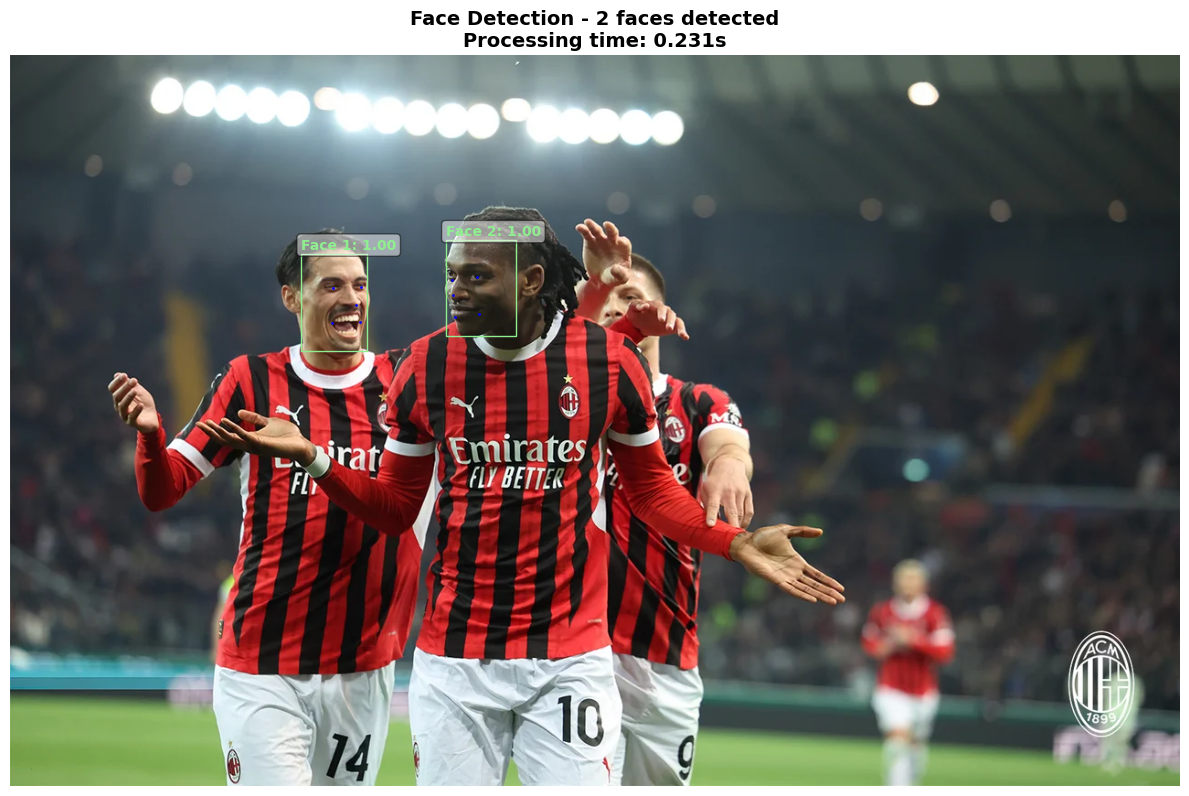

In [63]:
pipeline.visualize_detections(results)

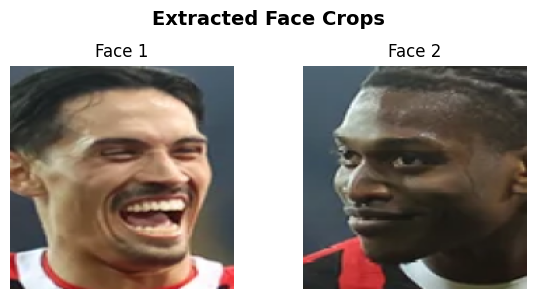

In [64]:
pipeline.visualize_face_crops(results)